# Fast Neural Style Transfer

In [1]:
# https://github.com/ceshine/fast-neural-style

In [2]:
import time 

import matplotlib.pyplot as plt
import numpy as np
import torch
# For getting VGG model
import torchvision.models.vgg as vgg
import torch.utils.model_zoo as model_zoo
# Image transformation pipeline
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.optim import Adam
from torch.autograd import Variable
from PIL import Image, ImageFile
from tqdm import tqdm_notebook

from fast_neural_style.transformer_net import TransformerNet
from fast_neural_style.utils import (
    gram_matrix, recover_image, tensor_normalizer
)
from fast_neural_style.loss_network import LossNetwork

%matplotlib inline
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
SEED = 1081
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    kwargs = {'num_workers': 4, 'pin_memory': True}
else:
    kwargs = {}

In [4]:
IMAGE_SIZE = 224
BATCH_SIZE = 4
DATASET = "./food_training" # Downloaded from http://images.cocodataset.org/zips/val2017.zip
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE), 
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(), tensor_normalizer()])
# http://pytorch.org/docs/master/torchvision/datasets.html#imagefolder
train_dataset = datasets.ImageFolder(DATASET, transform)
# http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, **kwargs)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
with torch.no_grad():
    loss_network = LossNetwork()
    loss_network.to(device)
loss_network.eval()

LossNetwork(
  (vgg_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1

In [6]:
loss_network

LossNetwork(
  (vgg_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1

In [7]:
STYLE_IMAGE = "./style_images/test_000021.jpg"
# STYLE_IMAGE = "./style_images/candy.jpg"
style_img = Image.open(STYLE_IMAGE).convert('RGB')
with torch.no_grad():
    style_img_tensor = transforms.Compose([
        # transforms.Resize(IMAGE_SIZE* 2),
        transforms.ToTensor(),
        tensor_normalizer()]
    )(style_img).unsqueeze(0)
    # assert np.sum(style_img - recover_image(style_img_tensor.numpy())[0].astype(np.uint8)) < 3 * style_img_tensor.size()[2] * style_img_tensor.size()[3]
    style_img_tensor = style_img_tensor.to(device)

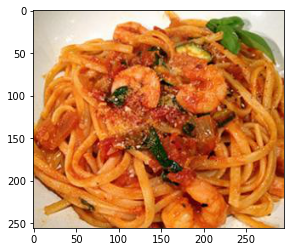

In [8]:
plt.imshow(recover_image(style_img_tensor.cpu().numpy())[0])

Precalculate gram matrices of the style image:

In [9]:
# http://pytorch.org/docs/master/notes/autograd.html#volatile
with torch.no_grad():
    style_loss_features = loss_network(style_img_tensor)
    gram_style = [gram_matrix(y) for y in style_loss_features]

In [10]:
style_loss_features._fields

('relu1', 'relu2', 'relu3', 'relu4', 'relu5')

In [11]:
for i in range(len(style_loss_features)):
    tmp = style_loss_features[i].cpu().numpy()
    print(i, np.mean(tmp), np.std(tmp))

0 0.7816211 1.3274428
1 1.1177801 2.4061673
2 1.414035 4.120414
3 0.43165287 1.65487
4 0.15624864 0.7467263


In [12]:
for i in range(len(style_loss_features)):
    print(i, gram_style[i].numel(), gram_style[i].size())

0 4096 torch.Size([1, 64, 64])
1 16384 torch.Size([1, 128, 128])
2 65536 torch.Size([1, 256, 256])
3 262144 torch.Size([1, 512, 512])
4 262144 torch.Size([1, 512, 512])


## Train the Transformer / Image Generator
Utility function to save debug images during training:

In [13]:
def save_debug_image(tensor_orig, tensor_transformed, tensor_with_noise, filename):
    assert tensor_orig.size() == tensor_transformed.size()
    result = Image.fromarray(recover_image(tensor_transformed.cpu().numpy())[0])
    noise = Image.fromarray(recover_image(tensor_with_noise.cpu().numpy())[0])
    orig = Image.fromarray(recover_image(tensor_orig.cpu().numpy())[0])
    new_im = Image.new('RGB', (result.size[0] * 3 + 10, result.size[1]))
    new_im.paste(orig, (0,0))
    new_im.paste(result, (result.size[0] + 5,0))
    new_im.paste(noise, (result.size[0] * 2 + 10,0))
    new_im.save(filename)

In [14]:
%mkdir -p debug

A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file debug already exists.
Error occurred while processing: debug.


In [15]:
transformer = TransformerNet()
mse_loss = torch.nn.MSELoss()
# l1_loss = torch.nn.L1Loss()
transformer.to(device)

TransformerNet(
  (conv1): ConvLayer(
    (reflection_pad): ReflectionPad2d((4, 4, 4, 4))
    (conv2d): Conv2d(3, 32, kernel_size=(9, 9), stride=(1, 1))
  )
  (in1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (conv2): ConvLayer(
    (reflection_pad): ReflectionPad2d((1, 1, 1, 1))
    (conv2d): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
  )
  (in2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (conv3): ConvLayer(
    (reflection_pad): ReflectionPad2d((1, 1, 1, 1))
    (conv2d): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
  )
  (in3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (res1): ResidualBlock(
    (conv1): ConvLayer(
      (reflection_pad): ReflectionPad2d((1, 1, 1, 1))
      (conv2d): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    )
    (in1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (

In [16]:
torch.set_default_tensor_type('torch.FloatTensor')
   
def train(steps, base_steps=0):
    transformer.train()
    count = 0
    agg_content_loss = 0.
    agg_style_loss = 0.
    agg_reg_loss = 0.   
    agg_stable_loss = 0.
    while True:
        for x, _ in train_loader:
            count += 1
            optimizer.zero_grad()
            x = x.to(device)             
            y = transformer(x)            
            with torch.no_grad():                      
                mask = torch.bernoulli(torch.ones_like(
                    x, device=device, dtype=torch.float
                ) * NOISE_P)
                noise = torch.normal(
                    torch.zeros_like(x), 
                    torch.ones_like(
                        x, device=device, dtype=torch.float
                    ) * NOISE_STD
                ).clamp(-1, 1)
                # print((noise * mask).sum())
            y_noise = transformer(x + noise * mask)
                        
            with torch.no_grad():
                xc = x.detach()
                features_xc = loss_network(xc)
            
            features_y = loss_network(y)
            
            with torch.no_grad():
                f_xc_c = features_xc[2].detach()

            content_loss = CONTENT_WEIGHT * mse_loss(features_y[2], f_xc_c)

            reg_loss = REGULARIZATION * (
                torch.sum(torch.abs(y[:, :, :, :-1] - y[:, :, :, 1:])) + 
                torch.sum(torch.abs(y[:, :, :-1, :] - y[:, :, 1:, :])))

            style_loss = 0.
            for l, weight in enumerate(STYLE_WEIGHTS):
                gram_s = gram_style[l]
                gram_y = gram_matrix(features_y[l])
                style_loss += float(weight) * mse_loss(gram_y, gram_s.expand_as(gram_y))
                
            stability_loss = NOISE_WEIGHT * mse_loss(y_noise.view(-1), y.view(-1).detach())

            total_loss = content_loss + style_loss + reg_loss + stability_loss
            total_loss.backward()
            optimizer.step()

            agg_content_loss += content_loss
            agg_style_loss += style_loss
            agg_reg_loss += reg_loss
            agg_stable_loss += stability_loss

            if count % LOG_INTERVAL == 0:
                mesg = "{} [{}/{}] content: {:.2f}  style: {:.2f}  reg: {:.2f} stable: {:.2f} total: {:.6f}".format(
                            time.ctime(), count, steps,
                            agg_content_loss / LOG_INTERVAL,
                            agg_style_loss / LOG_INTERVAL,
                            agg_reg_loss / LOG_INTERVAL,
                            agg_stable_loss / LOG_INTERVAL,
                            (agg_content_loss + agg_style_loss + 
                             agg_reg_loss + agg_stable_loss) / LOG_INTERVAL
                        )
                print(mesg)
                agg_content_loss = 0.
                agg_style_loss = 0.
                agg_reg_loss = 0.
                agg_stable_loss = 0.
                transformer.eval()
                y = transformer(x)
                save_debug_image(x, y.detach(), y_noise.detach(), "./debug/{}.png".format(base_steps + count))
                transformer.train()
                
            if count >= steps:
                return

In [17]:
len(train_loader)

7095

In [18]:
CONTENT_WEIGHT = 1
STYLE_WEIGHTS = np.array([1e-1, 1, 1e1, 5, 1e1]) * 5e3
REGULARIZATION = 1e-6
NOISE_P = 0.2
NOISE_STD = 0.35
NOISE_WEIGHT = 10 * 2
LOG_INTERVAL = 50

LR = 1e-3
optimizer = Adam(transformer.parameters(), LR)

In [42]:
train(200, 0)

Sun Jun 21 23:15:46 2020 [50/200] content: 11.60  style: 4.12  reg: 0.09 stable: 0.06 total: 15.868225
Sun Jun 21 23:16:32 2020 [100/200] content: 8.26  style: 3.07  reg: 0.11 stable: 0.04 total: 11.483818
Sun Jun 21 23:17:19 2020 [150/200] content: 6.71  style: 3.00  reg: 0.12 stable: 0.05 total: 9.869863
Sun Jun 21 23:18:02 2020 [200/200] content: 6.25  style: 2.83  reg: 0.12 stable: 0.05 total: 9.253166


In [43]:
save_model_path = "./models/spaghetti_style__200_iter__vgg19_weights.pth"
torch.save(transformer.state_dict(), save_model_path)

In [19]:
train(10000, 0)

Mon Jun 22 01:04:27 2020 [50/10000] content: 11.61  style: 4.08  reg: 0.09 stable: 0.06 total: 15.840216
Mon Jun 22 01:05:18 2020 [100/10000] content: 8.37  style: 3.05  reg: 0.11 stable: 0.03 total: 11.561810
Mon Jun 22 01:06:07 2020 [150/10000] content: 6.86  style: 3.05  reg: 0.12 stable: 0.05 total: 10.075295
Mon Jun 22 01:06:38 2020 [200/10000] content: 6.15  style: 2.84  reg: 0.12 stable: 0.05 total: 9.159331
Mon Jun 22 01:06:55 2020 [250/10000] content: 5.61  style: 2.81  reg: 0.13 stable: 0.06 total: 8.595103
Mon Jun 22 01:07:13 2020 [300/10000] content: 5.44  style: 3.04  reg: 0.13 stable: 0.06 total: 8.671140
Mon Jun 22 01:07:31 2020 [350/10000] content: 5.39  style: 2.92  reg: 0.13 stable: 0.07 total: 8.510863
Mon Jun 22 01:07:48 2020 [400/10000] content: 4.97  style: 2.91  reg: 0.13 stable: 0.06 total: 8.071739
Mon Jun 22 01:08:06 2020 [450/10000] content: 5.16  style: 2.76  reg: 0.14 stable: 0.06 total: 8.114506
Mon Jun 22 01:08:24 2020 [500/10000] content: 4.95  style: 2.

Mon Jun 22 01:28:58 2020 [4000/10000] content: 2.72  style: 2.96  reg: 0.15 stable: 0.13 total: 5.962365
Mon Jun 22 01:29:16 2020 [4050/10000] content: 2.45  style: 2.95  reg: 0.14 stable: 0.13 total: 5.672876
Mon Jun 22 01:29:33 2020 [4100/10000] content: 2.38  style: 2.96  reg: 0.15 stable: 0.12 total: 5.596403
Mon Jun 22 01:29:51 2020 [4150/10000] content: 2.29  style: 2.95  reg: 0.15 stable: 0.12 total: 5.509205
Mon Jun 22 01:30:09 2020 [4200/10000] content: 2.42  style: 3.00  reg: 0.15 stable: 0.13 total: 5.701613
Mon Jun 22 01:30:26 2020 [4250/10000] content: 2.72  style: 2.91  reg: 0.15 stable: 0.11 total: 5.891021
Mon Jun 22 01:30:44 2020 [4300/10000] content: 2.53  style: 2.89  reg: 0.15 stable: 0.13 total: 5.693872
Mon Jun 22 01:31:02 2020 [4350/10000] content: 2.65  style: 2.83  reg: 0.15 stable: 0.13 total: 5.763987
Mon Jun 22 01:31:20 2020 [4400/10000] content: 2.52  style: 2.88  reg: 0.15 stable: 0.13 total: 5.681354
Mon Jun 22 01:31:37 2020 [4450/10000] content: 2.48  st

Mon Jun 22 01:52:20 2020 [7950/10000] content: 2.01  style: 2.84  reg: 0.15 stable: 0.13 total: 5.122344
Mon Jun 22 01:52:38 2020 [8000/10000] content: 1.91  style: 2.97  reg: 0.15 stable: 0.13 total: 5.160039
Mon Jun 22 01:52:56 2020 [8050/10000] content: 2.09  style: 2.96  reg: 0.15 stable: 0.14 total: 5.334706
Mon Jun 22 01:53:13 2020 [8100/10000] content: 2.55  style: 2.91  reg: 0.15 stable: 0.14 total: 5.751269
Mon Jun 22 01:53:31 2020 [8150/10000] content: 2.67  style: 2.90  reg: 0.15 stable: 0.16 total: 5.884861
Mon Jun 22 01:53:49 2020 [8200/10000] content: 2.30  style: 3.04  reg: 0.15 stable: 0.17 total: 5.657936
Mon Jun 22 01:54:07 2020 [8250/10000] content: 2.23  style: 2.96  reg: 0.15 stable: 0.15 total: 5.483761
Mon Jun 22 01:54:24 2020 [8300/10000] content: 2.09  style: 2.97  reg: 0.15 stable: 0.13 total: 5.330442
Mon Jun 22 01:54:42 2020 [8350/10000] content: 2.11  style: 2.90  reg: 0.15 stable: 0.13 total: 5.289828
Mon Jun 22 01:55:00 2020 [8400/10000] content: 1.96  st

In [30]:
# optimizer = Adam(transformer.parameters(), LR * 0.5)

In [31]:
# train(3000, 1000)

In [21]:
save_model_path = "./models/spaghetti_style__10000_iter__vgg19_weights.pth"
torch.save(transformer.state_dict(), save_model_path)

In [22]:
# optimizer = Adam(transformer.parameters(), LR * 0.1)

In [68]:
# LOG_INTERVAL = 100
# train(6000, 4000)

In [24]:
# save_model_path = "./models/mosaic_10000_vgg19.pth"
# torch.save(transformer.state_dict(), save_model_path)

In [92]:
import glob
fnames = glob.glob(DATASET + r"/*/*")
len(fnames)

5000

In [93]:
transformer = transformer.eval()

C:\Users\datta\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:10: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  # Remove the CWD from sys.path while we load stuff.


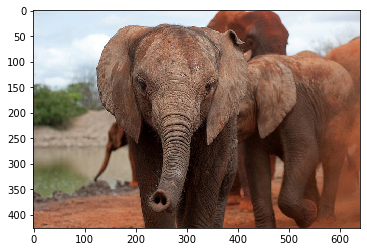

In [94]:
img = Image.open(fnames[70]).convert('RGB')
transform = transforms.Compose([
                                
                                transforms.ToTensor(),
                                tensor_normalizer()])
img_tensor = transform(img).unsqueeze(0)
if torch.cuda.is_available():
    img_tensor = img_tensor.cuda()

img_output = transformer(Variable(img_tensor, volatile=True))
plt.imshow(recover_image(img_tensor.cpu().numpy())[0])

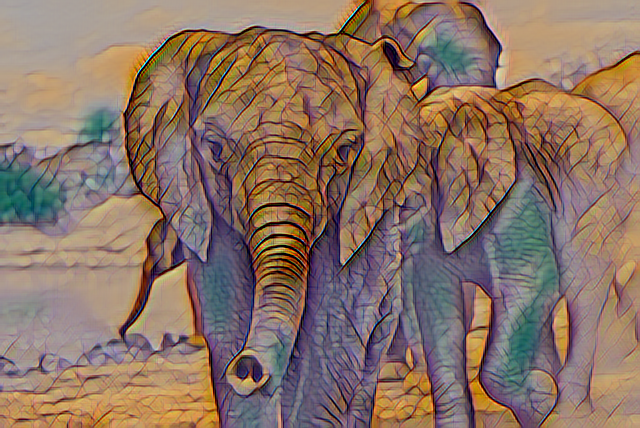

In [95]:
Image.fromarray(recover_image(img_output.data.cpu().numpy())[0])

C:\Users\datta\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:9: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  if __name__ == '__main__':


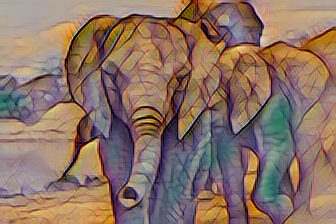

In [96]:
transform = transforms.Compose([
                                transforms.Resize(IMAGE_SIZE),
                                transforms.ToTensor(),
                                tensor_normalizer()])
img_tensor = transform(img).unsqueeze(0)
if torch.cuda.is_available():
    img_tensor = img_tensor.cuda()

img_output = transformer(Variable(img_tensor, volatile=True))
Image.fromarray(recover_image(img_output.data.cpu().numpy())[0])

#### custom image

torch.Size([1, 3, 512, 512])


C:\Users\datta\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:11: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  # This is added back by InteractiveShellApp.init_path()


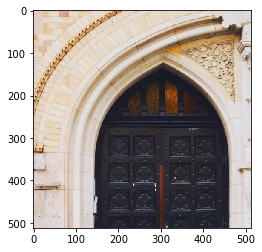

In [97]:
img = Image.open("./content_images/amber.jpg").convert('RGB')
transform = transforms.Compose([
    transforms.Resize(512),
    transforms.ToTensor(),
    tensor_normalizer()])
img_tensor = transform(img).unsqueeze(0)
print(img_tensor.size())
if torch.cuda.is_available():
    img_tensor = img_tensor.cuda()

img_output = transformer(Variable(img_tensor, volatile=True))
plt.imshow(recover_image(img_tensor.cpu().numpy())[0])

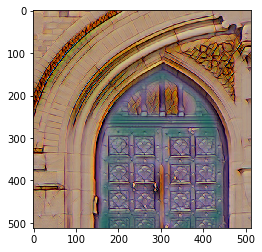

In [98]:
plt.imshow(recover_image(img_output.data.cpu().numpy())[0])

torch.Size([1, 3, 224, 224])


C:\Users\datta\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:11: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  # This is added back by InteractiveShellApp.init_path()


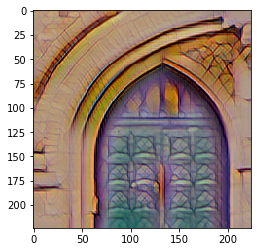

In [99]:
img = Image.open("./content_images/amber.jpg").convert('RGB')
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    tensor_normalizer()])
img_tensor = transform(img).unsqueeze(0)
print(img_tensor.size())
if torch.cuda.is_available():
    img_tensor = img_tensor.cuda()

img_output = transformer(Variable(img_tensor, volatile=True))
plt.imshow(recover_image(img_output.data.cpu().numpy())[0])

In [53]:
output_img = Image.fromarray(recover_image(img_output.data.cpu().numpy())[0])
output_img.save("amber.png")